# Application: Galaxy Classification

Galaxies come in [many different shapes](https://en.wikipedia.org/wiki/Galaxy_morphological_classification).  Large surveys can images 100,000s or millions of galaxies, and we want to be able to classify them into types.  We can use a neural network for this.

We will use the [Galaxy10 DECaLS dataset](https://astronn.readthedocs.io/en/latest/galaxy10.html) [(Leung & Bovy 2024)](https://zenodo.org/records/10845026),
which contains 17736 images of galaxies, each 256x256 pixels and 3 colors (g, r, and z bands), classified into 10 different categories.  It also provides RA and dec, redshift, and pixel scale---we'll ignore those.

You can get the dataset from Zenodo: [Galaxy10_DECals.h5](https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5)

This is an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file---this is a self-describing binary format that is popular in scientific computing.  We can read it in python using the
[h5py library](https://www.h5py.org/).

```{warning}
This is a big dataset (~2.5 GB), so we need to be careful with memory.  As we'll see below,
we'll keep the data in the original `uint8` form for as long as possible, converting it
to a float a galaxy at a time, as needed.
```

```{note}
There is no separate training and test set, so we need to partition the 17736 images ourselves.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

If we look at the dataset, we can see the fields:

In [2]:
ds = h5py.File("Galaxy10_DECals.h5")
ds.keys()

<KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>

let's look at the answers

In [3]:
ans = np.array(ds["ans"])
ans.shape, ans.dtype

((17736,), dtype('uint8'))

We see that there are 17736 records, stored as a NumPy array.

```{important}
The galaxies are stored in the dataset sorted by type.  So all of the "disturbed galaxies" (type `0`) come first, then the "merging galaxies", ...
```

## Exploring the data

Let's define descriptive names for the galaxy types

In [4]:
galaxy_types = {0: "disturbed galaxies",
                1: "merging galaxies",
                2: "round smooth galaxies",
                3: "in-between round smooth galaxies",
                4: "cigar shaped smooth galaxies",
                5: "barred spiral galaxies",
                6: "unbarred tight spiral galaxies",
                7: "unbarred loose spiral galaxies",
                8: "edge-on galaxies without bulge",
                9: "edge-on galaxies with bulge"}

We'll also create a simple class (`Galaxy`) to manage the data.

Here we pass in the image data for a single galaxy as a NumPy `uint8` array---the same datatype used in the file.  This class will convert it to a single precision floating-point array, scaled to fall between 0 and 1.  We also convert the answer to a categorical datatype (and array of length 10).

In [5]:
class Galaxy:
    def __init__(self, data, answer, *, index=-1):
        self.data = np.array(data, dtype=np.float32) / 255.0 * 0.99 + 0.01
        self.answer = answer

        self.out = np.zeros(10, dtype=np.float32) + 0.01
        self.out[self.answer] = 0.99

        self.index = index

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.imshow(self.data, interpolation="nearest")
        ax.text(0.025, 0.95, f"answer: {self.answer}",
                color="white", transform=ax.transAxes)

    def validate(self, prediction):
        """check if a categorical prediction matches the answer"""
        return np.argmax(prediction) == self.answer

Now let's find the first example of each type and plot it

In [6]:
images = ds["images"]
images.dtype

dtype('uint8')

```{note}
This doesn't read in the data.  It just provides a `Dataset` type that can be used
to access the data, so we can get a single galaxy at a time.
```

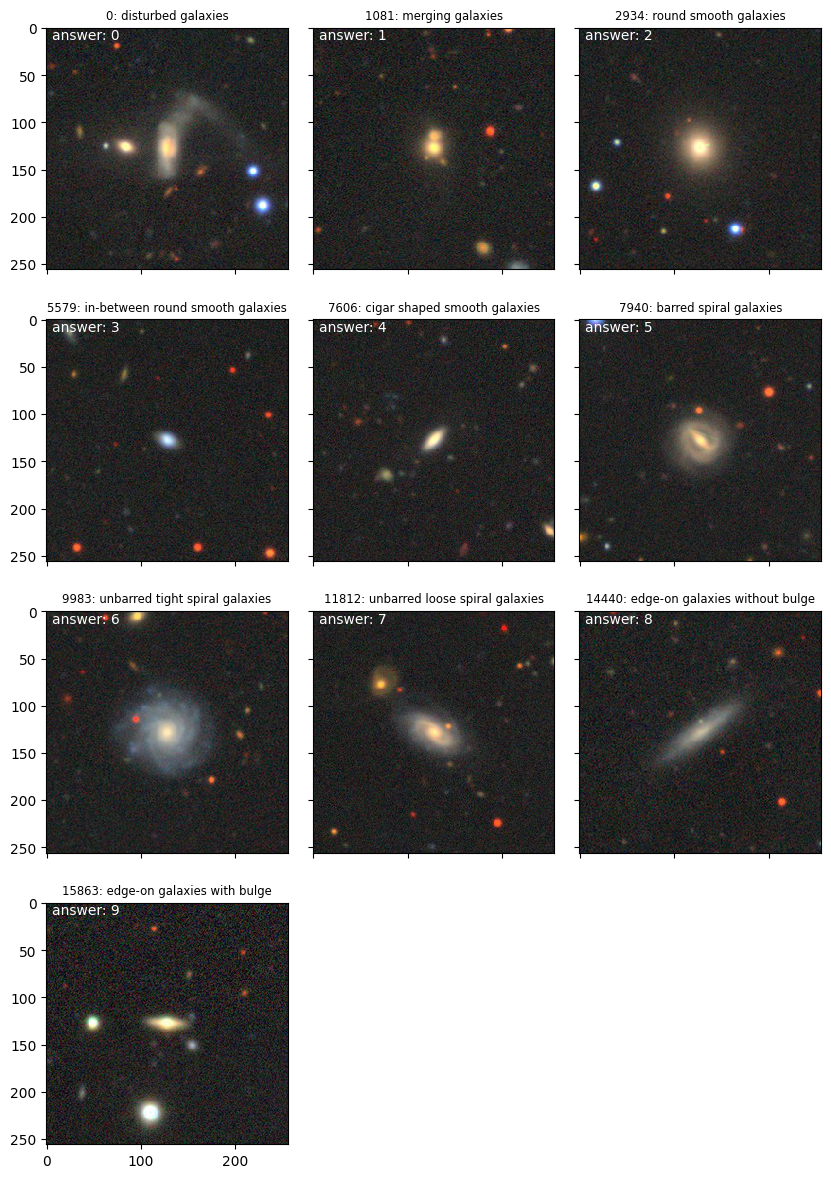

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure()
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 3),
                 axes_pad=(0.25, 0.5))

for i in range(10):
    idx = np.where(ans == i)[0][0]
    g = Galaxy(images[idx, :, :, :], ans[idx])
    g.plot(ax=grid[i])
    grid[i].set_title(f"{idx}: {galaxy_types[i]}", fontsize="small")

grid[10].set_axis_off()
grid[11].set_axis_off()
fig.set_size_inches(10, 15)

## A manager class

We'll create a class to manage access to the data.  This will do the following:

* open the file and store the handles to access the data
* partition the data into test and training sets
* provide a means to shuffle the data
* provide methods to get the next dataset (either training or test)
* allow us to coarsen the images to a reduced resolution to make the training easier.

```{important}
Since each class of galaxy is stored together in the file, we will want to
randomize the order before splitting into training and testing sets.
```

```{tip}
We'll provide 2 different ways of managing access to the data.  If `read_on_demand=True` is set,
then we only read the image data one at a time as needed to keep the memory requirements low.  This
uses a lot less memory, but the bulk of the training time will be spent on reading, and will take
more than an order of magnitude longer.

The default is to read all of the data once, which will take about 3.5 GB of memory.  It is kept
as a `uint8` until needed.
```

In [8]:
class DataManager:
    def __init__(self, partition=0.8,
                 datafile="Galaxy10_DECals.h5",
                 coarsen=1,
                 read_on_demand=False):
        """manage access to the data

        partition: fraction that should be training
        datafile: name of the hdf5 file with the data
        coarsen: reduce the number of pixels by this factor
        read_on_demand: do a only read the data from disk as needed?
        """

        self.ds = h5py.File(datafile)
        self.ans = np.array(self.ds["ans"])
        if read_on_demand:
            self.images = self.ds["images"]
        else:
            self.images = np.array(self.ds["images"])

        self.coarsen = coarsen

        N = len(self.ans)

        # create a set of indices for the galaxies and randomize
        self.indices = np.arange(N, dtype=np.uint32)
        self.rng = np.random.default_rng()
        self.rng.shuffle(self.indices)

        # partition into training and test sets
        # these indices will always refer to the index in the original
        # unsplit dataset
        n_cut = int(partition * N)
        self.training_indices = self.indices[0:n_cut]
        self.test_indices = self.indices[n_cut:N]

        self.n_training = len(self.training_indices)
        self.n_test = len(self.test_indices)
        
        # store the current index into the *_indices array we are
        # accessing
        self.curr_idx_train = -1
        self.curr_idx_test = -1

    def _get_galaxy(self, index):
        """return a numpy array containing a single galaxy image, coarsened
        if necessary by averaging"""
        _tmp = self.images[index, :, :, :]
        if self.coarsen > 1:
            _tmp = np.mean(_tmp.reshape(_tmp.shape[0]//self.coarsen, self.coarsen,
                                        _tmp.shape[1]//self.coarsen, self.coarsen,
                                        _tmp.shape[2]), axis=(1, 3))
        return _tmp

    def get_next_training_image(self):
        self.curr_idx_train += 1
        if self.curr_idx_train < len(self.training_indices):
            idx = self.training_indices[self.curr_idx_train]
            return Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)
        return None

    def reset_training(self):
        """prepare for the next epoch: shuffle the training data and
        reset the index to point to the start"""
        self.curr_idx_train = -1
        self.rng.shuffle(self.training_indices)

    def reset_testing(self):
        """reset the pointer for the test data"""
        self.curr_idx_test = -1

    def get_next_test_image(self):
        self.curr_idx_test += 1
        if self.curr_idx_test < len(self.test_indices):
            idx = self.test_indices[self.curr_idx_test]
            return Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)
        return None

````{tip}
The `get_next_training_image()` and `get_next_test_image()` will return `None` when there are no more galaxies.
This allows us to loop over the data set as:

```python
d = DataManager()
while g := d.get_next_training_image():
    # do stuff with g
```

where we use the [python walrus operator](https://peps.python.org/pep-0572/), `:=` to assign to `g` within the
loop conditional.
````

We can now work with the data as follows.  Here we create a `DataManager` that will coarsen the images by a factor of 4 (so they will be 64x64 pixels with 3 colors).

In [9]:
d = DataManager(coarsen=4)

we can see how many images there are in the training and test sets

In [10]:
d.n_training, d.n_test

(14188, 3548)

We can then get a training galaxy and look at it:

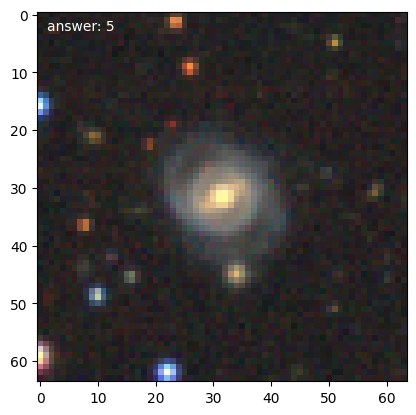

In [11]:
g = d.get_next_test_image()
g.plot()

We'll need a 1-d representation of the data, which we can get using `np.ravel()`

In [12]:
np.ravel(g.data).shape

(12288,)

## Batching

Training with this data will be very slow.  We can speed it up more by using batching and aggregating the linear algebra.  Here's how this works.

### Single input recap

Our basic network does:

$$\tilde{\bf z}^k = g({\bf B} {\bf x}^k)$$

$${\bf z}^k = g({\bf A} \tilde{\bf z}^k)$$

where the sizes of the matrices and vectors are:

* ${\bf x}^k$ : $N_\mathrm{in} \times 1$
* ${\bf B}$ : $N_\mathrm{hidden} \times N_\mathrm{in}$
* $\tilde{\bf z}^k$ : $N_\mathrm{hidden}\times 1$
* ${\bf A}$ : $N_\mathrm{out} \times N_\mathrm{hidden}$
* ${\bf z}^k$ : $N_\mathrm{out} \times 1$

we also have the known output, ${\bf y}^k$ corresponding to input ${\bf x}^k$

* ${\bf y}^k$ : $N_\mathrm{out} \times 1$

we then compute the errors:

* ${\bf e}^k = {\bf z}^k - {\bf y}^k$ (the error on the output layer) : $N_\mathrm{out} \times 1$
* $\tilde{\bf e}^k = {\bf A}^\intercal \cdot [{\bf e}^k \circ {\bf z} \circ (1 - {\bf z})]$ (the error backpropagated to the hidden layer) : $N_\mathrm{hidden} \times 1$

and finally the corrections due to this single piece of training data, $({\bf x}^k, {\bf y}^k)$:

* $\Delta {\bf A} = -2\eta \,{\bf e}^k \circ {\bf z}^k \circ (1 - {\bf z}^k) \cdot (\tilde{\bf z}^k)^\intercal$ : $N_\mathrm{out} \times N_\mathrm{hidden}$
* $\Delta {\bf B} = -2\eta \,\tilde{\bf e}^k \circ \tilde{\bf z}^k \circ (1 - \tilde{\bf z}^k) \cdot ({\bf x}^k)^\intercal$ : $N_\mathrm{hidden} \times N_\mathrm{in}$
  

### A batching approach

We now want to batch the inputs, by extending ${\bf x}$ to be of size $N_\mathrm{in} \times S$, where $S$ is the batch size.  This means that each column is a unique
input vector ${\bf x}^k$, and $S$ of them are sandwiched together:

$${\bf x}_b = \left ( \begin{array}{ccccc}
                      | & | & | &  & | \\
                      {\bf x}^0 & {\bf x}^1 & {\bf x}^2 & ... & {\bf x}^{S-1} \\
                      | & | & | &  & | 
                      \end{array} \right )$$

Similarly, we create a batched ${\bf y}_b$ that contains the ${\bf y}^k$ corresponding
to the ${\bf x}^k$ in ${\bf x}_b$.

We can propagate this through the network, getting

$${\bf z}_b = g({\bf A} g({\bf B}{\bf x}_b))$$

where ${\bf z}_b$ is now of size $N_\mathrm{out} \times S$.

Now, we compute the errors from the batched inputs

* ${\bf e}_b = {\bf z}_b - {\bf y}_b$ : $N_\mathrm{out} \times S$
* $\tilde{\bf e}_b =\underbrace{{\bf A}^\intercal}_{N_\mathrm{hidden} \times N_\mathrm{out}} \cdot \underbrace{[{\bf e}_b \circ {\bf z}_b \circ (1 - {\bf z})]}_{N_\mathrm{out} \times S}$ : $N_\mathrm{hidden} \times S$

and the accumulated corrections:

* $\Delta {\bf A} = -\frac{2\eta}{S} \,\underbrace{{\bf e}_b \circ {\bf z}_b \circ (1 - {\bf z}_b)}_{N_\mathrm{out}\times S} \cdot \underbrace{(\tilde{\bf z}_b)^\intercal}_{S\times N_\mathrm{hidden}}$
* $\Delta {\bf B} = -\frac{2\eta}{S} \,\underbrace{\tilde{\bf e}_b \circ \tilde{\bf z}_b \circ (1 - \tilde{\bf z}_b)}_{N_\mathrm{hidden} \times S} \cdot \underbrace{({\bf x}_b)^\intercal}_{S \times N_\mathrm{in}}$

In these accumulated corrections, the $S$ dimensions contract.  In essence, this means
that each element in $\Delta {\bf A}$ and $\Delta {\bf B}$ is the sum of the corrections for each of the $S$ training data pairs in the batch.  For this reason, we normalize by $S$ to create the average of the gradient.

```{tip}
Batching also stabilizes the gradient descent, making it easier to find
the minimum and allowing us to use a larger learning rate.
```

## Momentum

The other feature we need for this application is [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) in the gradient descent weight updates.

A popular form of momentum (see, e.g., [Momentum: A simple, yet efficient optimizing technique](https://medium.com/analytics-vidhya/momentum-a-simple-yet-efficient-optimizing-technique-ef76834e4423)) builds off of the idea of the [exponential moving average](https://en.wikipedia.org/wiki/Exponential_smoothing).


For our gradient descent update, we usually do:

$${\bf A} = {\bf A} - \eta \frac{\partial \mathcal{L}}{\partial {\bf A}}$$

where $\mathcal{L}$ is our loss function and $\eta$ is the learning rate.

The basic idea of momentum begins with defining a "velocity", ${\bf v}^{(0)} = 0$ (no momentum has been built up yet).
Then each iteration of training we do the following:

* construct the gradient from the current set of training, $\partial \mathcal{L}/\partial {\bf A}$

* blend this with the previous momentum using an exponential moving average:

  $${\bf v}^{(i)} = \beta {\bf v}^{(i-1)} + (1 - \beta) \frac{\partial \mathcal{L}}{\partial {\bf A}}$$

  where $\beta \in [0, 1]$ is the smoothing parameter.  It seems like $\beta = 0.9$ is used often.

  
  Since every gradient is always multiplied by $(1-\beta)$,
  and each previous gradient picks up a factor of $\beta$
  each iteration, this construction weights the most recent gradients most.
   
* update the weights:

  $${\bf A} = {\bf A} - \eta {\bf v}^{(i)}$$

We would do the same with the other weights, ${\bf B}$.

```{tip}
Momentum greatly reduces the swings in the "fraction correct" metric from one epoch to the next.
```

## Implementing our neural network

We'll write our network to take a `DataManager`---it can get everything that it needs from there.

In [13]:
import time

In [14]:
class NeuralNetwork:
    """A neural network class with a single hidden layer."""

    def __init__(self, data_manager, *, hidden_layer_size=20):

        self.data_manager = data_manager

        # let's get the first image from the training set and
        # use that to set the sizes
        g = self.data_manager.get_next_training_image()

        # the number of nodes/neurons on the output layer
        self.N_out = g.out.size

        # the number of nodes/neurons on the input layer
        self.N_in = np.ravel(g.data).size

        # the number of nodes/neurons on the hidden layer
        self.N_hidden = hidden_layer_size

        # we will initialize the weights with Gaussian normal random
        # numbers centered on 0 with a width of 1/sqrt(n), where n is
        # the length of the input state
        rng = np.random.default_rng()

        # A is the set of weights between the hidden layer and output layer
        self.A = np.zeros((self.N_out, self.N_hidden), dtype=np.float32)
        self.A[:, :] = rng.normal(0.0, 1.0/np.sqrt(self.N_hidden), self.A.shape)

        # B is the set of weights between the input layer and hidden layer
        self.B = np.zeros((self.N_hidden, self.N_in), dtype=np.float32)
        self.B[:, :] = rng.normal(0.0, 1.0/np.sqrt(self.N_in), self.B.shape)
        
        # reset the training
        self.data_manager.reset_training()

        self.n_trained = 0
        self.training_time = 0

    def sigmoid(self, xi):
        """our sigmoid function that operates on the hidden layer"""
        return 1.0/(1.0 + np.exp(-xi))

    def _batch_update(self, x_batch, y_batch):

        # batch size
        S = len(x_batch)

        x = np.array(x_batch).T
        y = np.array(y_batch).T

        # propagate the input through the network
        z_tilde = self.sigmoid(self.B @ x)
        z = self.sigmoid(self.A @ z_tilde)

        # compute the errors (backpropagate to the hidden layer)
        e = z - y
        e_tilde = self.A.T @ (e * z * (1 - z))

        # corrections
        grad_A = (2/S) * e * z * (1 - z) @ z_tilde.T
        grad_B = (2/S) * e_tilde * z_tilde * (1 - z_tilde) @ x.T

        self.n_trained += S
        
        return grad_A, grad_B

    def assess(self):
        """Run through the test data and return the fraction correct
        with the currently trained network"""
             
        self.data_manager.reset_testing()
        n_correct = 0
        while gt := self.data_manager.get_next_test_image():
            ans = self.predict(gt)
            if gt.validate(ans):
                n_correct += 1

        return n_correct / self.data_manager.n_test

    def train(self, *, n_epochs=1,
              learning_rate=0.2, beta_momentum=0.9,
              batch_size=64):
        """Train the neural network by doing gradient descent with back
        propagation to set the matrix elements in B (the weights
        between the input and hidden layer) and A (the weights between
        the hidden layer and output layer)
        """

        v_A = np.zeros_like(self.A)
        v_B = np.zeros_like(self.B)
        
        for i in range(n_epochs):

            start = time.perf_counter()

            self.data_manager.reset_training()

            # storage for our batches
            x_batch = []
            y_batch = []

            while g := self.data_manager.get_next_training_image():

                # make a 1-d representation of the input, called x, and call
                # the output y
                x_batch.append(np.ravel(g.data))
                y_batch.append(g.out)

                if len(x_batch) == batch_size:
                    # batch is full -- do the training
                    grad_A, grad_B = self._batch_update(x_batch, y_batch)

                    v_A[...] = beta_momentum * v_A + (1.0 - beta_momentum) * grad_A
                    v_B[...] = beta_momentum * v_B + (1.0 - beta_momentum) * grad_B

                    self.A[...] += -learning_rate * v_A
                    self.B[...] += -learning_rate * v_B

                    x_batch = []
                    y_batch = []

            # we may have run out of data without filling up the
            # last batch, so take care of that now
            if x_batch:
                grad_A, grad_B = self._batch_update(x_batch, y_batch)

                v_A[...] = beta_momentum * v_A + (1.0 - beta_momentum) * grad_A
                v_B[...] = beta_momentum * v_B + (1.0 - beta_momentum) * grad_B

                self.A[...] += -learning_rate * v_A
                self.B[...] += -learning_rate * v_B

            epoch_time = time.perf_counter() - start
            self.training_time += epoch_time

            frac_correct = self.assess()

            print(f"epoch {i+1:3} | " +
                  f"test set correct: {frac_correct:5.3f}; " +
                  f"training time: {epoch_time:7.3f} s")

    def predict(self, model):
        """ predict the outcome using our trained matrix A """
        x_in = np.ravel(model.data)[:, np.newaxis]
        y = self.sigmoid(self.A @ (self.sigmoid(self.B @ x_in)))
        return y

In [15]:
nn = NeuralNetwork(d, hidden_layer_size=400)

In [16]:
nn.train(n_epochs=20)

epoch   1 | test set correct: 0.154; training time:  39.656 s
epoch   2 | test set correct: 0.227; training time:  39.535 s
epoch   3 | test set correct: 0.255; training time:  39.552 s
epoch   4 | test set correct: 0.249; training time:  39.814 s
epoch   5 | test set correct: 0.300; training time:  39.911 s
epoch   6 | test set correct: 0.280; training time:  39.315 s
epoch   7 | test set correct: 0.299; training time:  39.194 s
epoch   8 | test set correct: 0.315; training time:  39.017 s
epoch   9 | test set correct: 0.357; training time:  39.172 s
epoch  10 | test set correct: 0.351; training time:  39.179 s
epoch  11 | test set correct: 0.363; training time:  39.290 s
epoch  12 | test set correct: 0.375; training time:  39.067 s
epoch  13 | test set correct: 0.391; training time:  39.005 s
epoch  14 | test set correct: 0.399; training time:  39.175 s
epoch  15 | test set correct: 0.393; training time:  38.915 s
epoch  16 | test set correct: 0.410; training time:  39.263 s
epoch  1

In [17]:
nn.n_trained

283760